### Import Dataset

In [5]:
from GvaDataset import GvaDataset
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import v2
import os
import random
random.seed(137)

PROJECT_DIR = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing"

train_transform = v2.Compose([
    v2.Resize((1024, 512)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomAffine(degrees=5, translate=(0.2, 0.2)),
    v2.ColorJitter()
])

test_transform = v2.Compose([
    v2.Resize((1024, 512))
])


train_images_path = os.path.join(PROJECT_DIR, "data/images/train")
train_labels_path = os.path.join(PROJECT_DIR, "data/labels/train")

test_images_path = os.path.join(PROJECT_DIR, "data/images/test")
test_labels_path = os.path.join(PROJECT_DIR, "data/labels/test")


train_dataset = GvaDataset(train_images_path, train_labels_path, transform=train_transform)
test_dataset = GvaDataset(test_images_path, test_labels_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Visualize Data Transforms

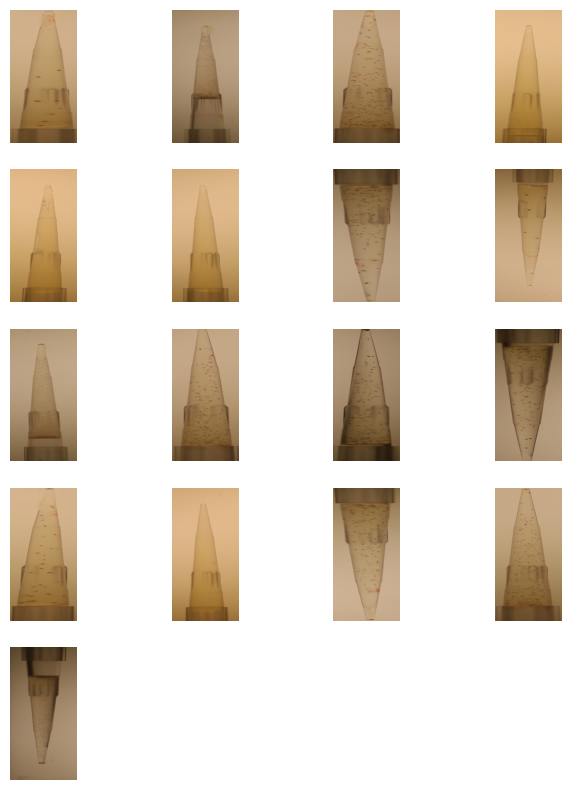

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(train_loader), 4, figsize=(8, len(train_loader) * 2))
for i, data in enumerate(train_loader):
    imgs, labs, files = data

    for j in range(4):
        if j < imgs.shape[0]:
            img = imgs[j].permute(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
        else:
            ax[i, j].set_visible(False)
    
    

### Train Model

In [8]:
from models.unet import UNet
from experiment import Experiment
from losses import dice_loss
import torch.optim as optim
import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters())
criterion = dice_loss
experiment = Experiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    device=device, 
    name="flipping-color-jitter-4-5", 
    bench=200)

In [9]:
experiment.train(train_loader=train_loader, validation_loader=test_loader, epochs=600)

Epoch 0/600: 100%|█| 5/5 [00:03<00:00,  1.30batch/s, avg_loss=0.972, loss=0.965]


1/600 train_loss: 0.9723654389381409 val loss: 0.9792668968439102


Epoch 1/600: 100%|██| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.96, loss=0.926]


2/600 train_loss: 0.9604356169700623 val loss: 0.9781161099672318


Epoch 2/600: 100%|█████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.973, loss=1]


3/600 train_loss: 0.9727567434310913 val loss: 0.9777224212884903


Epoch 3/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.967, loss=0.999]


4/600 train_loss: 0.9673526763916016 val loss: 0.9794570952653885


Epoch 4/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.959, loss=0.934]


5/600 train_loss: 0.9589261054992676 val loss: 0.9734608232975006


Epoch 5/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.952, loss=0.907]


6/600 train_loss: 0.9517894506454467 val loss: 0.9699137210845947


Epoch 6/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.956, loss=0.953]


7/600 train_loss: 0.9557450175285339 val loss: 0.970076248049736


Epoch 7/600: 100%|██| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.947, loss=0.94]


8/600 train_loss: 0.9474493861198425 val loss: 0.9724959135055542


Epoch 8/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.953, loss=0.996]


9/600 train_loss: 0.9525870561599732 val loss: 0.9683220088481903


Epoch 9/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.943, loss=0.948]


10/600 train_loss: 0.9427464962005615 val loss: 0.9525897651910782


Epoch 10/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.924, loss=0.871


11/600 train_loss: 0.9238798260688782 val loss: 0.9585142880678177


Epoch 11/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.922, loss=0.85]


12/600 train_loss: 0.9220186352729798 val loss: 0.9608622491359711


Epoch 12/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.932, loss=0.892


13/600 train_loss: 0.9323509812355042 val loss: 0.9460181593894958


Epoch 13/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.941, loss=0.97]


14/600 train_loss: 0.9413808703422546 val loss: 0.9429189115762711


Epoch 14/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.932, loss=0.988


15/600 train_loss: 0.9324621200561524 val loss: 0.9442790299654007


Epoch 15/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.939, loss=0.995


16/600 train_loss: 0.9385587453842164 val loss: 0.9354889541864395


Epoch 16/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.918, loss=0.983


17/600 train_loss: 0.9175866723060608 val loss: 0.7776381522417068


Epoch 17/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.902, loss=0.927


18/600 train_loss: 0.9023210525512695 val loss: 0.8484145998954773


Epoch 18/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.926, loss=0.994


19/600 train_loss: 0.9264933943748475 val loss: 0.963888555765152


Epoch 19/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.869, loss=0.735


20/600 train_loss: 0.8687942385673523 val loss: 0.9602145105600357


Epoch 20/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.912, loss=0.976


21/600 train_loss: 0.91195627450943 val loss: 0.9439485669136047


Epoch 21/600: 100%|█████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.91, loss=1]


22/600 train_loss: 0.9100317597389221 val loss: 0.8429497182369232


Epoch 22/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.907, loss=0.997


23/600 train_loss: 0.9074851751327515 val loss: 0.7978564351797104


Epoch 23/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.903, loss=0.834


24/600 train_loss: 0.9031299710273742 val loss: 0.8892560452222824


Epoch 24/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.845, loss=0.995


25/600 train_loss: 0.8451536536216736 val loss: 0.735154926776886


Epoch 25/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.906, loss=0.88]


26/600 train_loss: 0.9056944131851197 val loss: 0.9158150553703308


Epoch 26/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.861, loss=0.894


27/600 train_loss: 0.8613486409187316 val loss: 0.7153213918209076


Epoch 27/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.819, loss=0.973


28/600 train_loss: 0.8192584753036499 val loss: 0.7403293550014496


Epoch 28/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.866, loss=0.997


29/600 train_loss: 0.8661747097969055 val loss: 0.7210638225078583


Epoch 29/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.831, loss=0.511


30/600 train_loss: 0.8311004877090454 val loss: 0.702923521399498


Epoch 30/600: 100%|██| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.85, loss=0.92]


31/600 train_loss: 0.8501833796501159 val loss: 0.6857900172472


Epoch 31/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.786, loss=0.422


32/600 train_loss: 0.7858384728431702 val loss: 0.6161970496177673


Epoch 32/600: 100%|██| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.89, loss=0.99]


33/600 train_loss: 0.890434181690216 val loss: 0.7632960081100464


Epoch 33/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.853, loss=0.757


34/600 train_loss: 0.8531557798385621 val loss: 0.6122278422117233


Epoch 34/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.877, loss=0.957


35/600 train_loss: 0.877154552936554 val loss: 0.5454418063163757


Epoch 35/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.892, loss=1]


36/600 train_loss: 0.8917908787727356 val loss: 0.5300054997205734


Epoch 36/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.843, loss=0.947


37/600 train_loss: 0.8427086591720581 val loss: 0.5282282680273056


Epoch 37/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.635, loss=0.311


38/600 train_loss: 0.6353194236755371 val loss: 0.538990318775177


Epoch 38/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.842, loss=0.911


39/600 train_loss: 0.8421829342842102 val loss: 0.5388209223747253


Epoch 39/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.936, loss=0.905


40/600 train_loss: 0.935797119140625 val loss: 0.529828280210495


Epoch 40/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.921, loss=1]


41/600 train_loss: 0.9214662313461304 val loss: 0.5288033038377762


Epoch 41/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.884, loss=0.997


42/600 train_loss: 0.8843622088432312 val loss: 0.5393665432929993


Epoch 42/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.866, loss=1]


43/600 train_loss: 0.8660829782485961 val loss: 0.6662978231906891


Epoch 43/600: 100%|████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.858, loss=1]


44/600 train_loss: 0.8576726317405701 val loss: 0.6868417412042618


Epoch 44/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.916, loss=0.953


45/600 train_loss: 0.9156300067901612 val loss: 0.8482030034065247


Epoch 45/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.901, loss=0.949


46/600 train_loss: 0.9011341452598571 val loss: 0.8336301147937775


Epoch 46/600: 100%|████| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.869, loss=1]


47/600 train_loss: 0.8690405368804932 val loss: 0.5742013901472092


Epoch 47/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.821, loss=1]


48/600 train_loss: 0.8212712287902832 val loss: 0.5967470556497574


Epoch 48/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.868, loss=0.961


49/600 train_loss: 0.8679637432098388 val loss: 0.5130811184644699


Epoch 49/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.82, loss=0.9]


50/600 train_loss: 0.8202108860015869 val loss: 0.511594146490097


Epoch 50/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.842, loss=0.537


51/600 train_loss: 0.8416378021240234 val loss: 0.5047515481710434


Epoch 51/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.893, loss=0.965


52/600 train_loss: 0.8932663202285767 val loss: 0.5015250444412231


Epoch 52/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.716, loss=0.977


53/600 train_loss: 0.7156104326248169 val loss: 0.504128485918045


Epoch 53/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.889, loss=0.931


54/600 train_loss: 0.8888732552528381 val loss: 0.4971059411764145


Epoch 54/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.871, loss=0.997


55/600 train_loss: 0.8708236455917359 val loss: 0.500994086265564


Epoch 55/600: 100%|████| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.769, loss=1]


56/600 train_loss: 0.7685967326164246 val loss: 0.4927932918071747


Epoch 56/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.763, loss=0.964


57/600 train_loss: 0.7632369518280029 val loss: 0.5135336369276047


Epoch 57/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.723, loss=1]


58/600 train_loss: 0.7228805541992187 val loss: 0.5140792727470398


Epoch 58/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.822, loss=1]


59/600 train_loss: 0.8224029421806336 val loss: 0.495384082198143


Epoch 59/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.876, loss=0.968


60/600 train_loss: 0.8756089210510254 val loss: 0.5123591274023056


Epoch 60/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.777, loss=0.992


61/600 train_loss: 0.7774893403053283 val loss: 0.48232637345790863


Epoch 61/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.933, loss=0.978


62/600 train_loss: 0.932700264453888 val loss: 0.4988532215356827


Epoch 62/600: 100%|█| 5/5 [00:03<00:00,  1.44batch/s, avg_loss=0.75, loss=0.415]


63/600 train_loss: 0.7500691413879395 val loss: 0.5162207931280136


Epoch 63/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.717, loss=0.507


64/600 train_loss: 0.717242169380188 val loss: 0.5354593843221664


Epoch 64/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.848, loss=0.87]


65/600 train_loss: 0.84803546667099 val loss: 0.5056161135435104


Epoch 65/600: 100%|██| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.91, loss=0.97]


66/600 train_loss: 0.910245132446289 val loss: 0.5258373022079468


Epoch 66/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.73, loss=0.294]


67/600 train_loss: 0.7304603338241578 val loss: 0.5486647486686707


Epoch 67/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.867, loss=0.911


68/600 train_loss: 0.8670907378196716 val loss: 0.4895113855600357


Epoch 68/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.765, loss=0.344


69/600 train_loss: 0.7654186606407165 val loss: 0.48940409719944


Epoch 69/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.693, loss=0.383


70/600 train_loss: 0.6930954694747925 val loss: 0.4933425635099411


Epoch 70/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.65, loss=0.262]


71/600 train_loss: 0.6498881936073303 val loss: 0.5024218857288361


Epoch 71/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.767, loss=0.872


72/600 train_loss: 0.7670602440834046 val loss: 0.747101828455925


Epoch 72/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.837, loss=0.928


73/600 train_loss: 0.8369368791580201 val loss: 0.7959865182638168


Epoch 73/600: 100%|████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.853, loss=1]


74/600 train_loss: 0.8533708453178406 val loss: 0.8393208831548691


Epoch 74/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.8, loss=0.89]


75/600 train_loss: 0.8000269532203674 val loss: 0.782806396484375


Epoch 75/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.688, loss=0.358


76/600 train_loss: 0.687822949886322 val loss: 0.5210308283567429


Epoch 76/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.764, loss=0.869


77/600 train_loss: 0.7639436721801758 val loss: 0.48595087230205536


Epoch 77/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.838, loss=0.997


78/600 train_loss: 0.8375871062278748 val loss: 0.49124443531036377


Epoch 78/600: 100%|████| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.868, loss=1]


79/600 train_loss: 0.8678590655326843 val loss: 0.48229341208934784


Epoch 79/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.762, loss=0.933


80/600 train_loss: 0.7622898101806641 val loss: 0.4467129558324814


Epoch 80/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.804, loss=0.926


81/600 train_loss: 0.8035451412200928 val loss: 0.4403114318847656


Epoch 81/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.845, loss=0.958


82/600 train_loss: 0.844956386089325 val loss: 0.451307013630867


Epoch 82/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.911, loss=0.892


83/600 train_loss: 0.9105154037475586 val loss: 0.4594143480062485


Epoch 83/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.867, loss=0.883


84/600 train_loss: 0.8665227651596069 val loss: 0.49173615872859955


Epoch 84/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.867, loss=0.954


85/600 train_loss: 0.8668824911117554 val loss: 0.5290105044841766


Epoch 85/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.935, loss=1]


86/600 train_loss: 0.9354273080825806 val loss: 0.736051395535469


Epoch 86/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.791, loss=0.986


87/600 train_loss: 0.7908309102058411 val loss: 0.5759133547544479


Epoch 87/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.866, loss=0.938


88/600 train_loss: 0.8660999417304993 val loss: 0.5080745369195938


Epoch 88/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.767, loss=0.952


89/600 train_loss: 0.7674787282943726 val loss: 0.500425860285759


Epoch 89/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.833, loss=0.972


90/600 train_loss: 0.832896614074707 val loss: 0.49192431569099426


Epoch 90/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.677, loss=0.858


91/600 train_loss: 0.6765558123588562 val loss: 0.5151733309030533


Epoch 91/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.772, loss=0.893


92/600 train_loss: 0.7717589378356934 val loss: 0.5570439249277115


Epoch 92/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.795, loss=0.529


93/600 train_loss: 0.7950483441352845 val loss: 0.5745247304439545


Epoch 93/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.855, loss=1]


94/600 train_loss: 0.8547509193420411 val loss: 0.5033008754253387


Epoch 94/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.878, loss=0.875


95/600 train_loss: 0.8781078219413757 val loss: 0.5198166221380234


Epoch 95/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.803, loss=0.976


96/600 train_loss: 0.8030535817146301 val loss: 0.8424593210220337


Epoch 96/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.843, loss=0.961


97/600 train_loss: 0.843008303642273 val loss: 0.8374267965555191


Epoch 97/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.716, loss=0.366


98/600 train_loss: 0.7160489320755005 val loss: 0.6811056137084961


Epoch 98/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.874, loss=1]


99/600 train_loss: 0.8743651270866394 val loss: 0.6490571051836014


Epoch 99/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.875, loss=1]


100/600 train_loss: 0.8754356384277344 val loss: 0.6746773421764374


Epoch 100/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.853, loss=0.84


101/600 train_loss: 0.8531771779060364 val loss: 0.7597508430480957


Epoch 101/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.76, loss=0.42]


102/600 train_loss: 0.7598868250846863 val loss: 0.5173618793487549


Epoch 102/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.823, loss=0.99


103/600 train_loss: 0.8226925015449524 val loss: 0.49640925228595734


Epoch 103/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.85, loss=0.937


104/600 train_loss: 0.8496098637580871 val loss: 0.506011426448822


Epoch 104/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.847, loss=0.93


105/600 train_loss: 0.8467022776603699 val loss: 0.5053280144929886


Epoch 105/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.849, loss=0.91


106/600 train_loss: 0.8488985538482666 val loss: 0.49200718104839325


Epoch 106/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.835, loss=0.95


107/600 train_loss: 0.8349288702011108 val loss: 0.528096079826355


Epoch 107/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.762, loss=0.33


108/600 train_loss: 0.7617347002029419 val loss: 0.5186816304922104


Epoch 108/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.762, loss=0.28


109/600 train_loss: 0.7618151783943177 val loss: 0.5094618052244186


Epoch 109/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.815, loss=0.97


110/600 train_loss: 0.8151185393333436 val loss: 0.5405992865562439


Epoch 110/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.909, loss=0.94


111/600 train_loss: 0.9090920209884643 val loss: 0.5400816351175308


Epoch 111/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.846, loss=0.90


112/600 train_loss: 0.8463485956192016 val loss: 0.5324754416942596


Epoch 112/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.83, loss=1]


113/600 train_loss: 0.8298141360282898 val loss: 0.5922850072383881


Epoch 113/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.805, loss=0.96


114/600 train_loss: 0.8050656795501709 val loss: 0.5066853910684586


Epoch 114/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.826, loss=1]


115/600 train_loss: 0.826124107837677 val loss: 0.48537272214889526


Epoch 115/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.881, loss=1]


116/600 train_loss: 0.8810393810272217 val loss: 0.4812812954187393


Epoch 116/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.858, loss=0.99


117/600 train_loss: 0.857627022266388 val loss: 0.5014405399560928


Epoch 117/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.813, loss=0.83


118/600 train_loss: 0.813168203830719 val loss: 0.5024465471506119


Epoch 118/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.828, loss=0.99


119/600 train_loss: 0.8278728723526001 val loss: 0.4852823466062546


Epoch 119/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.724, loss=1]


120/600 train_loss: 0.7239303827285767 val loss: 0.4974502623081207


Epoch 120/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.856, loss=0.99


121/600 train_loss: 0.8562957763671875 val loss: 0.49641653895378113


Epoch 121/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.829, loss=0.90


122/600 train_loss: 0.8288879156112671 val loss: 0.4988514482975006


Epoch 122/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.83, loss=0.97]


123/600 train_loss: 0.8303460121154785 val loss: 0.5031544268131256


Epoch 123/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.662, loss=0.47


124/600 train_loss: 0.6616539359092712 val loss: 0.4816485196352005


Epoch 124/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.922, loss=0.89


125/600 train_loss: 0.9215054988861084 val loss: 0.4909389615058899


Epoch 125/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.848, loss=0.97


126/600 train_loss: 0.848241674900055 val loss: 0.5772123485803604


Epoch 126/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.668, loss=0.30


127/600 train_loss: 0.6677719950675964 val loss: 0.9408028423786163


Epoch 127/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.875, loss=0.98


128/600 train_loss: 0.8750620007514953 val loss: 0.9024052172899246


Epoch 128/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.834, loss=0.96


129/600 train_loss: 0.8344423532485962 val loss: 0.5075210332870483


Epoch 129/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.829, loss=0.96


130/600 train_loss: 0.8285967230796814 val loss: 0.4874066710472107


Epoch 130/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.86, loss=1]


131/600 train_loss: 0.8599539875984192 val loss: 0.5144866108894348


Epoch 131/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.837, loss=0.95


132/600 train_loss: 0.8373776197433471 val loss: 0.5188747644424438


Epoch 132/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.914, loss=0.85


133/600 train_loss: 0.9140288829803467 val loss: 0.4950459450483322


Epoch 133/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.805, loss=0.85


134/600 train_loss: 0.8047824621200561 val loss: 0.4938019961118698


Epoch 134/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.846, loss=0.99


135/600 train_loss: 0.846336555480957 val loss: 0.5075139403343201


Epoch 135/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.899, loss=1]


136/600 train_loss: 0.8991965532302857 val loss: 0.5156490802764893


Epoch 136/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.743, loss=0.87


137/600 train_loss: 0.743483817577362 val loss: 0.4923412650823593


Epoch 137/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.777, loss=0.93


138/600 train_loss: 0.7767992615699768 val loss: 0.5192939788103104


Epoch 138/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.793, loss=1]


139/600 train_loss: 0.7927295207977295 val loss: 0.5082540959119797


Epoch 139/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.877, loss=0.82


140/600 train_loss: 0.876851749420166 val loss: 0.4821927845478058


Epoch 140/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.789, loss=0.98


141/600 train_loss: 0.7890191674232483 val loss: 0.47656111419200897


Epoch 141/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.807, loss=0.95


142/600 train_loss: 0.807059133052826 val loss: 0.486589714884758


Epoch 142/600: 100%|█| 5/5 [00:03<00:00,  1.45batch/s, avg_loss=0.698, loss=0.98


143/600 train_loss: 0.6980262875556946 val loss: 0.48317790031433105


Epoch 143/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.83, loss=1]


144/600 train_loss: 0.829790222644806 val loss: 0.49210479855537415


Epoch 144/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.733, loss=0.94


145/600 train_loss: 0.733383059501648 val loss: 0.5465251058340073


Epoch 145/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.879, loss=0.95


146/600 train_loss: 0.8793739557266236 val loss: 0.5448718965053558


Epoch 146/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.74, loss=0.394


147/600 train_loss: 0.739674699306488 val loss: 0.5266795456409454


Epoch 147/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.812, loss=0.97


148/600 train_loss: 0.8118033528327941 val loss: 0.5090193748474121


Epoch 148/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.671, loss=0.97


149/600 train_loss: 0.6706299543380737 val loss: 0.5052470564842224


Epoch 149/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.835, loss=0.96


150/600 train_loss: 0.8354504704475403 val loss: 0.496710941195488


Epoch 150/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.72, loss=0.296


151/600 train_loss: 0.7202110528945923 val loss: 0.48945075273513794


Epoch 151/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.698, loss=0.21


152/600 train_loss: 0.6984633922576904 val loss: 0.49067555367946625


Epoch 152/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.651, loss=0.40


153/600 train_loss: 0.650604498386383 val loss: 0.49283964931964874


Epoch 153/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.901, loss=0.92


154/600 train_loss: 0.9013387084007263 val loss: 0.5351088345050812


Epoch 154/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.787, loss=0.95


155/600 train_loss: 0.7866709113121033 val loss: 0.5018526315689087


Epoch 155/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.848, loss=0.93


156/600 train_loss: 0.8477101445198059 val loss: 0.516612708568573


Epoch 156/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.715, loss=0.91


157/600 train_loss: 0.7154377460479736 val loss: 0.46135905385017395


Epoch 157/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.76, loss=0.944


158/600 train_loss: 0.7604950070381165 val loss: 0.46062202751636505


Epoch 158/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.575, loss=0.34


159/600 train_loss: 0.5747461676597595 val loss: 0.461289644241333


Epoch 159/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.736, loss=1]


160/600 train_loss: 0.7361345767974854 val loss: 0.48307062685489655


Epoch 160/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.897, loss=0.97


161/600 train_loss: 0.897198212146759 val loss: 0.48035527765750885


Epoch 161/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.695, loss=0.98


162/600 train_loss: 0.6949086427688599 val loss: 0.4701583981513977


Epoch 162/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.916, loss=0.91


163/600 train_loss: 0.9159375071525574 val loss: 0.480136901140213


Epoch 163/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.661, loss=0.29


164/600 train_loss: 0.6614142060279846 val loss: 0.5219705998897552


Epoch 164/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.778, loss=0.35


165/600 train_loss: 0.7777164340019226 val loss: 0.6041545420885086


Epoch 165/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.814, loss=0.91


166/600 train_loss: 0.8142731428146363 val loss: 0.5845316052436829


Epoch 166/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.701, loss=0.62


167/600 train_loss: 0.7013313174247742 val loss: 0.5166202932596207


Epoch 167/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.818, loss=1]


168/600 train_loss: 0.8179617404937745 val loss: 0.5195672661066055


Epoch 168/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.841, loss=0.97


169/600 train_loss: 0.8407107710838317 val loss: 0.5191262513399124


Epoch 169/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.835, loss=0.96


170/600 train_loss: 0.8347091436386108 val loss: 0.5200958102941513


Epoch 170/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.721, loss=0.35


171/600 train_loss: 0.7208752274513245 val loss: 0.4946587532758713


Epoch 171/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.809, loss=0.96


172/600 train_loss: 0.8094647526741028 val loss: 0.4807898849248886


Epoch 172/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.816, loss=0.95


173/600 train_loss: 0.8163861870765686 val loss: 0.5158746838569641


Epoch 173/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.85, loss=1]


174/600 train_loss: 0.8498785614967346 val loss: 0.5101861506700516


Epoch 174/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.874, loss=0.96


175/600 train_loss: 0.8739688754081726 val loss: 0.49654577672481537


Epoch 175/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.859, loss=1]


176/600 train_loss: 0.8588165879249573 val loss: 0.5017649978399277


Epoch 176/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.878, loss=0.88


177/600 train_loss: 0.8782047867774964 val loss: 0.5339617282152176


Epoch 177/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.836, loss=1]


178/600 train_loss: 0.8358324050903321 val loss: 0.5498912781476974


Epoch 178/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.737, loss=0.51


179/600 train_loss: 0.7369254112243653 val loss: 0.5058338940143585


Epoch 179/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.648, loss=0.34


180/600 train_loss: 0.6482521057128906 val loss: 0.5032387226819992


Epoch 180/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.74, loss=0.975


181/600 train_loss: 0.7398206472396851 val loss: 0.469378337264061


Epoch 181/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.849, loss=1]


182/600 train_loss: 0.8487529277801513 val loss: 0.49723416566848755


Epoch 182/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.788, loss=0.97


183/600 train_loss: 0.7882726669311524 val loss: 0.5434978753328323


Epoch 183/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.867, loss=0.87


184/600 train_loss: 0.8667954683303833 val loss: 0.5426577478647232


Epoch 184/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.905, loss=1]


185/600 train_loss: 0.9050944089889527 val loss: 0.5120930075645447


Epoch 185/600: 100%|████| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.82, loss=1]


186/600 train_loss: 0.819862174987793 val loss: 0.4945579320192337


Epoch 186/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.876, loss=1]


187/600 train_loss: 0.8757505774497986 val loss: 0.49164004623889923


Epoch 187/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.826, loss=0.97


188/600 train_loss: 0.8255889892578125 val loss: 0.4818798452615738


Epoch 188/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.764, loss=0.86


189/600 train_loss: 0.7638474822044372 val loss: 0.5041619688272476


Epoch 189/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.841, loss=0.96


190/600 train_loss: 0.8414712309837341 val loss: 0.487847700715065


Epoch 190/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.824, loss=0.86


191/600 train_loss: 0.8236688137054443 val loss: 0.4882001280784607


Epoch 191/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.852, loss=0.92


192/600 train_loss: 0.851745319366455 val loss: 0.49186474084854126


Epoch 192/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.935, loss=1]


193/600 train_loss: 0.9352217555046082 val loss: 0.5093270391225815


Epoch 193/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.78, loss=0.468


194/600 train_loss: 0.7803953051567077 val loss: 0.6774519681930542


Epoch 194/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.684, loss=0.26


195/600 train_loss: 0.6839652299880982 val loss: 0.5951594859361649


Epoch 195/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.788, loss=0.93


196/600 train_loss: 0.787800920009613 val loss: 0.6085363626480103


Epoch 196/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.707, loss=0.92


197/600 train_loss: 0.7074814796447754 val loss: 0.5580736696720123


Epoch 197/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.934, loss=1]


198/600 train_loss: 0.933726167678833 val loss: 0.5219465792179108


Epoch 198/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.933, loss=0.96


199/600 train_loss: 0.9332497596740723 val loss: 0.4856954663991928


Epoch 199/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.906, loss=0.87


200/600 train_loss: 0.906467604637146 val loss: 0.5395256876945496


Epoch 200/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.856, loss=0.94


201/600 train_loss: 0.856474494934082 val loss: 0.5209825187921524


Epoch 201/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.796, loss=0.87


202/600 train_loss: 0.7962452173233032 val loss: 0.407824382185936


Epoch 202/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.902, loss=0.94


203/600 train_loss: 0.9020975470542908 val loss: 0.47503265738487244


Epoch 203/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.787, loss=0.97


204/600 train_loss: 0.7870598912239075 val loss: 0.4536249190568924


Epoch 204/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.743, loss=0.63


205/600 train_loss: 0.743037486076355 val loss: 0.5018316358327866


Epoch 205/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.805, loss=0.95


206/600 train_loss: 0.805369246006012 val loss: 0.5629424750804901


Epoch 206/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.892, loss=0.96


207/600 train_loss: 0.892089593410492 val loss: 0.4850812256336212


Epoch 207/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.696, loss=0.91


208/600 train_loss: 0.695647919178009 val loss: 0.5151669681072235


Epoch 208/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.789, loss=0.98


209/600 train_loss: 0.788568913936615 val loss: 0.4818873107433319


Epoch 209/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.825, loss=1]


210/600 train_loss: 0.8246522188186646 val loss: 0.5369798988103867


Epoch 210/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.717, loss=0.34


211/600 train_loss: 0.7169128060340881 val loss: 0.5103404819965363


Epoch 211/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.935, loss=0.94


212/600 train_loss: 0.9347970247268677 val loss: 0.515520840883255


Epoch 212/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.904, loss=0.90


213/600 train_loss: 0.9040259718894958 val loss: 0.5867712944746017


Epoch 213/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.874, loss=1]


214/600 train_loss: 0.8742908954620361 val loss: 0.5449116080999374


Epoch 214/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.769, loss=0.92


215/600 train_loss: 0.7694494485855102 val loss: 0.5036039054393768


Epoch 215/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.723, loss=0.94


216/600 train_loss: 0.7229398012161254 val loss: 0.4614752531051636


Epoch 216/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.858, loss=0.94


217/600 train_loss: 0.8583365559577942 val loss: 0.4768022894859314


Epoch 217/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.784, loss=0.39


218/600 train_loss: 0.7837664127349854 val loss: 0.47333595156669617


Epoch 218/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.783, loss=0.96


219/600 train_loss: 0.7825091242790222 val loss: 0.6450650691986084


Epoch 219/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.912, loss=0.91


220/600 train_loss: 0.9123448014259339 val loss: 0.6745557934045792


Epoch 220/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.738, loss=0.96


221/600 train_loss: 0.7382308959960937 val loss: 0.6319421082735062


Epoch 221/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.878, loss=0.86


222/600 train_loss: 0.877562415599823 val loss: 0.5608771294355392


Epoch 222/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.883, loss=1]


223/600 train_loss: 0.8830031752586365 val loss: 0.4722774624824524


Epoch 223/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.698, loss=0.99


224/600 train_loss: 0.6975282549858093 val loss: 0.4962482154369354


Epoch 224/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.892, loss=0.91


225/600 train_loss: 0.8919257521629333 val loss: 0.51899653673172


Epoch 225/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.693, loss=0.34


226/600 train_loss: 0.6934700727462768 val loss: 0.47200994193553925


Epoch 226/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.756, loss=0.83


227/600 train_loss: 0.7560856103897095 val loss: 0.47358840703964233


Epoch 227/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.866, loss=0.94


228/600 train_loss: 0.8663012146949768 val loss: 0.48971687257289886


Epoch 228/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.749, loss=0.98


229/600 train_loss: 0.749315333366394 val loss: 0.5211073309183121


Epoch 229/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.892, loss=0.97


230/600 train_loss: 0.892201042175293 val loss: 0.5758709758520126


Epoch 230/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.773, loss=0.37


231/600 train_loss: 0.7728084325790405 val loss: 0.6923215240240097


Epoch 231/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.881, loss=0.88


232/600 train_loss: 0.8808159112930298 val loss: 0.5655076056718826


Epoch 232/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.708, loss=0.41


233/600 train_loss: 0.7077043056488037 val loss: 0.5374390780925751


Epoch 233/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.797, loss=0.92


234/600 train_loss: 0.7974893450737 val loss: 0.611049234867096


Epoch 234/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.817, loss=0.97


235/600 train_loss: 0.817155921459198 val loss: 0.6103189587593079


Epoch 235/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.885, loss=1]


236/600 train_loss: 0.8852637529373169 val loss: 0.5404204428195953


Epoch 236/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.894, loss=0.96


237/600 train_loss: 0.8938266038894653 val loss: 0.4902968853712082


Epoch 237/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.805, loss=0.98


238/600 train_loss: 0.8047091364860535 val loss: 0.48840928077697754


Epoch 238/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.873, loss=1]


239/600 train_loss: 0.8734391093254089 val loss: 0.5049514472484589


Epoch 239/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.841, loss=0.87


240/600 train_loss: 0.8414208292961121 val loss: 0.5042770653963089


Epoch 240/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.907, loss=0.92


241/600 train_loss: 0.9065661191940307 val loss: 0.5433512777090073


Epoch 241/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.789, loss=0.78


242/600 train_loss: 0.7893145561218262 val loss: 0.48070868849754333


Epoch 242/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.734, loss=0.79


243/600 train_loss: 0.7339627742767334 val loss: 0.48359623551368713


Epoch 243/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.757, loss=0.99


244/600 train_loss: 0.7572264552116394 val loss: 0.48221276700496674


Epoch 244/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.853, loss=0.97


245/600 train_loss: 0.853162944316864 val loss: 0.5002718865871429


Epoch 245/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.891, loss=0.99


246/600 train_loss: 0.8914772987365722 val loss: 0.5609807223081589


Epoch 246/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.688, loss=0.96


247/600 train_loss: 0.6882121324539184 val loss: 0.5237103402614594


Epoch 247/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.758, loss=0.86


248/600 train_loss: 0.7581171870231629 val loss: 0.49127809703350067


Epoch 248/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.927, loss=0.90


249/600 train_loss: 0.927418565750122 val loss: 0.49349217116832733


Epoch 249/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.914, loss=0.98


250/600 train_loss: 0.9141276836395263 val loss: 0.5094961822032928


Epoch 250/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.792, loss=0.96


251/600 train_loss: 0.7921481966972351 val loss: 0.5081288516521454


Epoch 251/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.721, loss=0.99


252/600 train_loss: 0.7213735103607177 val loss: 0.5018838196992874


Epoch 252/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.75, loss=0.931


253/600 train_loss: 0.7502282381057739 val loss: 0.48344551026821136


Epoch 253/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.764, loss=1]


254/600 train_loss: 0.7640452861785889 val loss: 0.4964968115091324


Epoch 254/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.832, loss=0.96


255/600 train_loss: 0.8323827385902405 val loss: 0.49491390585899353


Epoch 255/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.746, loss=0.96


256/600 train_loss: 0.7463853240013123 val loss: 0.4854004830121994


Epoch 256/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.698, loss=0.99


257/600 train_loss: 0.6979498982429504 val loss: 0.47494399547576904


Epoch 257/600: 100%|█| 5/5 [00:03<00:00,  1.45batch/s, avg_loss=0.725, loss=0.21


258/600 train_loss: 0.7248829245567322 val loss: 0.4831843078136444


Epoch 258/600: 100%|█| 5/5 [00:03<00:00,  1.45batch/s, avg_loss=0.861, loss=0.91


259/600 train_loss: 0.8606494307518006 val loss: 0.4841390550136566


Epoch 259/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.834, loss=1]


260/600 train_loss: 0.8335769653320313 val loss: 0.4700499325990677


Epoch 260/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.84, loss=1]


261/600 train_loss: 0.8396639227867126 val loss: 0.4742272198200226


Epoch 261/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.896, loss=0.95


262/600 train_loss: 0.8961398482322693 val loss: 0.5200195461511612


Epoch 262/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.796, loss=0.90


263/600 train_loss: 0.7962849617004395 val loss: 0.5664303600788116


Epoch 263/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.904, loss=1]


264/600 train_loss: 0.9036399126052856 val loss: 0.5975968539714813


Epoch 264/600: 100%|█████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.8, loss=1]


265/600 train_loss: 0.8004068374633789 val loss: 0.52243672311306


Epoch 265/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.63, loss=0.209


266/600 train_loss: 0.6298911690711975 val loss: 0.4955838918685913


Epoch 266/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.813, loss=0.99


267/600 train_loss: 0.8128828287124634 val loss: 0.4899928569793701


Epoch 267/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.744, loss=0.99


268/600 train_loss: 0.744417405128479 val loss: 0.4763520359992981


Epoch 268/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.715, loss=0.25


269/600 train_loss: 0.7151409983634949 val loss: 0.4684530347585678


Epoch 269/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.709, loss=0.42


270/600 train_loss: 0.7091642022132874 val loss: 0.46001170575618744


Epoch 270/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.791, loss=0.90


271/600 train_loss: 0.7908356547355652 val loss: 0.47313202917575836


Epoch 271/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.85, loss=0.914


272/600 train_loss: 0.8497856974601745 val loss: 0.47101788222789764


Epoch 272/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.789, loss=0.98


273/600 train_loss: 0.7887850522994995 val loss: 0.487836554646492


Epoch 273/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.854, loss=0.96


274/600 train_loss: 0.8541184186935424 val loss: 0.5240915715694427


Epoch 274/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.839, loss=0.97


275/600 train_loss: 0.8390782594680786 val loss: 0.5112947076559067


Epoch 275/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.646, loss=0.32


276/600 train_loss: 0.6461726188659668 val loss: 0.47632788121700287


Epoch 276/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.806, loss=1]


277/600 train_loss: 0.806065809726715 val loss: 0.4754750579595566


Epoch 277/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.782, loss=1]


278/600 train_loss: 0.782194995880127 val loss: 0.48115871846675873


Epoch 278/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.875, loss=1]


279/600 train_loss: 0.8751384615898132 val loss: 0.4850241392850876


Epoch 279/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.893, loss=0.97


280/600 train_loss: 0.8934447526931762 val loss: 0.49528244137763977


Epoch 280/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.805, loss=0.94


281/600 train_loss: 0.8054960370063782 val loss: 0.5196443498134613


Epoch 281/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.872, loss=0.90


282/600 train_loss: 0.8715824007987976 val loss: 0.5388807058334351


Epoch 282/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.72, loss=0.321


283/600 train_loss: 0.7197929978370666 val loss: 0.5463594347238541


Epoch 283/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.901, loss=0.97


284/600 train_loss: 0.9009817481040955 val loss: 0.5678540617227554


Epoch 284/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.847, loss=1]


285/600 train_loss: 0.8474337816238403 val loss: 0.5385248363018036


Epoch 285/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.808, loss=0.99


286/600 train_loss: 0.808147394657135 val loss: 0.4779258817434311


Epoch 286/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.836, loss=0.99


287/600 train_loss: 0.8362499475479126 val loss: 0.47598543763160706


Epoch 287/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.895, loss=1]


288/600 train_loss: 0.8954017043113709 val loss: 0.4623415023088455


Epoch 288/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.856, loss=0.96


289/600 train_loss: 0.8560354351997376 val loss: 0.46150583028793335


Epoch 289/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.933, loss=0.96


290/600 train_loss: 0.9332266330718995 val loss: 0.48079487681388855


Epoch 290/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.783, loss=0.93


291/600 train_loss: 0.7831781029701232 val loss: 0.49393558502197266


Epoch 291/600: 100%|█| 5/5 [00:03<00:00,  1.45batch/s, avg_loss=0.844, loss=0.80


292/600 train_loss: 0.8440974354743958 val loss: 0.4875258803367615


Epoch 292/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.884, loss=1]


293/600 train_loss: 0.8840834498405457 val loss: 0.483926385641098


Epoch 293/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.835, loss=0.83


294/600 train_loss: 0.8350478768348694 val loss: 0.4890349954366684


Epoch 294/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.877, loss=0.99


295/600 train_loss: 0.8772815704345703 val loss: 0.4860498756170273


Epoch 295/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.804, loss=0.93


296/600 train_loss: 0.8035448789596558 val loss: 0.6123339235782623


Epoch 296/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.783, loss=1]


297/600 train_loss: 0.7833986759185791 val loss: 0.6548478454351425


Epoch 297/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.873, loss=1]


298/600 train_loss: 0.8728785872459411 val loss: 0.47877001762390137


Epoch 298/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.87, loss=1]


299/600 train_loss: 0.8697891473770142 val loss: 0.46846748888492584


Epoch 299/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.881, loss=1]


300/600 train_loss: 0.8809571027755737 val loss: 0.5065490156412125


Epoch 300/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.872, loss=0.96


301/600 train_loss: 0.8721166610717773 val loss: 0.5088553726673126


Epoch 301/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.822, loss=0.97


302/600 train_loss: 0.822343385219574 val loss: 0.4701671004295349


Epoch 302/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.719, loss=0.23


303/600 train_loss: 0.7190817713737487 val loss: 0.4716531038284302


Epoch 303/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.851, loss=0.96


304/600 train_loss: 0.851381802558899 val loss: 0.48871974647045135


Epoch 304/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.853, loss=0.87


305/600 train_loss: 0.8529650449752808 val loss: 0.5023832619190216


Epoch 305/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.747, loss=0.43


306/600 train_loss: 0.7470824122428894 val loss: 0.5167843699455261


Epoch 306/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.854, loss=0.88


307/600 train_loss: 0.8541118621826171 val loss: 0.5028802007436752


Epoch 307/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.869, loss=0.82


308/600 train_loss: 0.8690581440925598 val loss: 0.5507265478372574


Epoch 308/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.872, loss=1]


309/600 train_loss: 0.872459864616394 val loss: 0.5820476710796356


Epoch 309/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.862, loss=0.90


310/600 train_loss: 0.8620165467262269 val loss: 0.5317296534776688


Epoch 310/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.858, loss=0.92


311/600 train_loss: 0.8581555366516114 val loss: 0.49210016429424286


Epoch 311/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.716, loss=1]


312/600 train_loss: 0.7157622814178467 val loss: 0.4781086891889572


Epoch 312/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.687, loss=0.34


313/600 train_loss: 0.6867213368415832 val loss: 0.4826839119195938


Epoch 313/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.799, loss=0.96


314/600 train_loss: 0.798973000049591 val loss: 0.47268079221248627


Epoch 314/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.85, loss=0.984


315/600 train_loss: 0.8499688029289245 val loss: 0.4689137190580368


Epoch 315/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.599, loss=0.34


316/600 train_loss: 0.5985731363296509 val loss: 0.46929629147052765


Epoch 316/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.842, loss=0.98


317/600 train_loss: 0.8420326948165894 val loss: 0.46735116839408875


Epoch 317/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.775, loss=0.92


318/600 train_loss: 0.7749766349792481 val loss: 0.4768584221601486


Epoch 318/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.852, loss=0.92


319/600 train_loss: 0.8515184164047241 val loss: 0.47329047322273254


Epoch 319/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.847, loss=0.94


320/600 train_loss: 0.8465160608291626 val loss: 0.4742608666419983


Epoch 320/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.753, loss=0.82


321/600 train_loss: 0.7528310775756836 val loss: 0.6130779683589935


Epoch 321/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.76, loss=0.966


322/600 train_loss: 0.7599517822265625 val loss: 0.675188809633255


Epoch 322/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.665, loss=0.89


323/600 train_loss: 0.6652018070220947 val loss: 0.538892075419426


Epoch 323/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.827, loss=1]


324/600 train_loss: 0.8269477725028992 val loss: 0.5139707028865814


Epoch 324/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.715, loss=0.96


325/600 train_loss: 0.7151367545127869 val loss: 0.5249025225639343


Epoch 325/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.826, loss=1]


326/600 train_loss: 0.825992202758789 val loss: 0.525401160120964


Epoch 326/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.891, loss=0.92


327/600 train_loss: 0.8912534594535828 val loss: 0.5534431338310242


Epoch 327/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.884, loss=0.85


328/600 train_loss: 0.8841400742530823 val loss: 0.597746342420578


Epoch 328/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.861, loss=0.95


329/600 train_loss: 0.8613019585609436 val loss: 0.7395907342433929


Epoch 329/600: 100%|████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.72, loss=1]


330/600 train_loss: 0.7196834206581115 val loss: 0.802462711930275


Epoch 330/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.924, loss=1]


331/600 train_loss: 0.9242408156394959 val loss: 0.6090774983167648


Epoch 331/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.637, loss=0.46


332/600 train_loss: 0.6366802334785462 val loss: 0.5380542427301407


Epoch 332/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.796, loss=0.83


333/600 train_loss: 0.7956821322441101 val loss: 0.5603056997060776


Epoch 333/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.689, loss=0.90


334/600 train_loss: 0.6890490889549256 val loss: 0.5912294387817383


Epoch 334/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.824, loss=0.98


335/600 train_loss: 0.8240507364273071 val loss: 0.5915814191102982


Epoch 335/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.603, loss=0.34


336/600 train_loss: 0.6028675079345703 val loss: 0.564968928694725


Epoch 336/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.948, loss=1]


337/600 train_loss: 0.9481494665145874 val loss: 0.5968925952911377


Epoch 337/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.873, loss=1]


338/600 train_loss: 0.8729228138923645 val loss: 0.495651438832283


Epoch 338/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.742, loss=1]


339/600 train_loss: 0.7416419506072998 val loss: 0.505056843161583


Epoch 339/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.799, loss=0.91


340/600 train_loss: 0.7989532947540283 val loss: 0.5337835848331451


Epoch 340/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.853, loss=1]


341/600 train_loss: 0.8526526927947998 val loss: 0.5105316638946533


Epoch 341/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.873, loss=0.95


342/600 train_loss: 0.8733694911003113 val loss: 0.4983575791120529


Epoch 342/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.838, loss=1]


343/600 train_loss: 0.838219404220581 val loss: 0.4946001321077347


Epoch 343/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.773, loss=0.92


344/600 train_loss: 0.7732427954673767 val loss: 0.48307326436042786


Epoch 344/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.866, loss=1]


345/600 train_loss: 0.865544855594635 val loss: 0.49975840747356415


Epoch 345/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.82, loss=0.888


346/600 train_loss: 0.8195726275444031 val loss: 0.5378533154726028


Epoch 346/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.782, loss=1]


347/600 train_loss: 0.7824786543846131 val loss: 0.5126685351133347


Epoch 347/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.568, loss=0.31


348/600 train_loss: 0.5678586959838867 val loss: 0.4853811115026474


Epoch 348/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.817, loss=0.92


349/600 train_loss: 0.8166130423545838 val loss: 0.49717147648334503


Epoch 349/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.814, loss=1]


350/600 train_loss: 0.8142454385757446 val loss: 0.5208249539136887


Epoch 350/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.826, loss=0.96


351/600 train_loss: 0.8262114644050598 val loss: 0.528960183262825


Epoch 351/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.689, loss=0.82


352/600 train_loss: 0.6886459589004517 val loss: 0.6025533080101013


Epoch 352/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.792, loss=0.95


353/600 train_loss: 0.7915337324142456 val loss: 0.5688575059175491


Epoch 353/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.603, loss=0.28


354/600 train_loss: 0.6034762263298035 val loss: 0.48831403255462646


Epoch 354/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.611, loss=0.29


355/600 train_loss: 0.6112536311149597 val loss: 0.4566141664981842


Epoch 355/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.815, loss=1]


356/600 train_loss: 0.8145302176475525 val loss: 0.4089915603399277


Epoch 356/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.778, loss=1]


357/600 train_loss: 0.7780889987945556 val loss: 0.41311316192150116


Epoch 357/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.774, loss=0.82


358/600 train_loss: 0.7739017486572266 val loss: 0.43422943353652954


Epoch 358/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.824, loss=1]


359/600 train_loss: 0.8238330364227295 val loss: 0.5952627658843994


Epoch 359/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.741, loss=0.91


360/600 train_loss: 0.7405279517173767 val loss: 0.45021164417266846


Epoch 360/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.852, loss=0.99


361/600 train_loss: 0.8520466685295105 val loss: 0.5172707885503769


Epoch 361/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.939, loss=0.97


362/600 train_loss: 0.9393389105796814 val loss: 0.5545639544725418


Epoch 362/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.838, loss=0.91


363/600 train_loss: 0.8380437135696411 val loss: 0.5567616075277328


Epoch 363/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.759, loss=0.47


364/600 train_loss: 0.7585001349449157 val loss: 0.5101032257080078


Epoch 364/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.827, loss=0.89


365/600 train_loss: 0.8269921064376831 val loss: 0.4840366095304489


Epoch 365/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.724, loss=0.93


366/600 train_loss: 0.7241336822509765 val loss: 0.5186201632022858


Epoch 366/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.875, loss=1]


367/600 train_loss: 0.8746316313743592 val loss: 0.6012198477983475


Epoch 367/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.838, loss=0.98


368/600 train_loss: 0.8381462931632996 val loss: 0.6714520007371902


Epoch 368/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.89, loss=0.999


369/600 train_loss: 0.8903174042701721 val loss: 0.765021875500679


Epoch 369/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.861, loss=1]


370/600 train_loss: 0.860831332206726 val loss: 0.7686613351106644


Epoch 370/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.797, loss=0.97


371/600 train_loss: 0.7966295599937439 val loss: 0.4936417192220688


Epoch 371/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.723, loss=0.76


372/600 train_loss: 0.7231210589408874 val loss: 0.4694151133298874


Epoch 372/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.835, loss=1]


373/600 train_loss: 0.8350283145904541 val loss: 0.560432180762291


Epoch 373/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.817, loss=0.99


374/600 train_loss: 0.8169961214065552 val loss: 0.5507330149412155


Epoch 374/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.831, loss=0.97


375/600 train_loss: 0.8309296250343323 val loss: 0.49189335107803345


Epoch 375/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.801, loss=1]


376/600 train_loss: 0.8014333486557007 val loss: 0.46515098214149475


Epoch 376/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.841, loss=0.96


377/600 train_loss: 0.8411153674125671 val loss: 0.46388882398605347


Epoch 377/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.767, loss=0.97


378/600 train_loss: 0.7667149901390076 val loss: 0.4685702621936798


Epoch 378/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.841, loss=0.99


379/600 train_loss: 0.8413009524345398 val loss: 0.5074120908975601


Epoch 379/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.893, loss=0.94


380/600 train_loss: 0.8933236360549927 val loss: 0.7512527406215668


Epoch 380/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.831, loss=1]


381/600 train_loss: 0.8313127875328064 val loss: 0.8617236763238907


Epoch 381/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.853, loss=0.92


382/600 train_loss: 0.8532702922821045 val loss: 0.5503790378570557


Epoch 382/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.824, loss=0.99


383/600 train_loss: 0.8243666052818298 val loss: 0.48181430995464325


Epoch 383/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.764, loss=0.93


384/600 train_loss: 0.7636674880981446 val loss: 0.4699096083641052


Epoch 384/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.794, loss=0.68


385/600 train_loss: 0.7942272424697876 val loss: 0.46787281334400177


Epoch 385/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.651, loss=0.38


386/600 train_loss: 0.6506607055664062 val loss: 0.45610854029655457


Epoch 386/600: 100%|█████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.9, loss=1]


387/600 train_loss: 0.900190806388855 val loss: 0.46025465428829193


Epoch 387/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.742, loss=0.34


388/600 train_loss: 0.7418168067932129 val loss: 0.5218517929315567


Epoch 388/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.743, loss=0.90


389/600 train_loss: 0.7430289149284363 val loss: 0.5240732431411743


Epoch 389/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.823, loss=0.98


390/600 train_loss: 0.822576642036438 val loss: 0.5302878320217133


Epoch 390/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.737, loss=0.88


391/600 train_loss: 0.7369258403778076 val loss: 0.5128162056207657


Epoch 391/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.776, loss=0.94


392/600 train_loss: 0.7761372089385986 val loss: 0.5294321179389954


Epoch 392/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.661, loss=1]


393/600 train_loss: 0.6610902190208435 val loss: 0.5022307187318802


Epoch 393/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.722, loss=1]


394/600 train_loss: 0.7220076560974121 val loss: 0.49786992371082306


Epoch 394/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.704, loss=0.71


395/600 train_loss: 0.703896415233612 val loss: 0.4827350676059723


Epoch 395/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.871, loss=0.98


396/600 train_loss: 0.8705434799194336 val loss: 0.5340906381607056


Epoch 396/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.894, loss=0.93


397/600 train_loss: 0.8939308285713196 val loss: 0.5585431158542633


Epoch 397/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.849, loss=0.97


398/600 train_loss: 0.8489761114120483 val loss: 0.6633849889039993


Epoch 398/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.915, loss=0.96


399/600 train_loss: 0.9150158524513244 val loss: 0.7687114179134369


Epoch 399/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.762, loss=0.44


400/600 train_loss: 0.761848795413971 val loss: 0.5874918103218079


Epoch 400/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.788, loss=0.96


401/600 train_loss: 0.7882492184638977 val loss: 0.5153101235628128


Epoch 401/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.894, loss=1]


402/600 train_loss: 0.8936650872230529 val loss: 0.6575139462947845


Epoch 402/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.789, loss=0.44


403/600 train_loss: 0.788586699962616 val loss: 0.5100438147783279


Epoch 403/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.796, loss=0.93


404/600 train_loss: 0.7955679774284363 val loss: 0.5315332859754562


Epoch 404/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.638, loss=0.99


405/600 train_loss: 0.6382114291191101 val loss: 0.47255177795886993


Epoch 405/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.732, loss=0.28


406/600 train_loss: 0.731606638431549 val loss: 0.4639646112918854


Epoch 406/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.913, loss=0.90


407/600 train_loss: 0.9130747437477111 val loss: 0.46356961131095886


Epoch 407/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.842, loss=0.97


408/600 train_loss: 0.8424589395523071 val loss: 0.48617738485336304


Epoch 408/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.773, loss=0.54


409/600 train_loss: 0.7727675318717957 val loss: 0.5134497880935669


Epoch 409/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.829, loss=0.97


410/600 train_loss: 0.8288248896598815 val loss: 0.5455116033554077


Epoch 410/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.801, loss=0.51


411/600 train_loss: 0.8008966326713562 val loss: 0.5180438756942749


Epoch 411/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.595, loss=0.34


412/600 train_loss: 0.5947282195091248 val loss: 0.4606831520795822


Epoch 412/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.881, loss=0.95


413/600 train_loss: 0.8805569529533386 val loss: 0.48719578981399536


Epoch 413/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.819, loss=0.94


414/600 train_loss: 0.8190956830978393 val loss: 0.5089940428733826


Epoch 414/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.786, loss=0.86


415/600 train_loss: 0.7860734105110169 val loss: 0.4884463995695114


Epoch 415/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.86, loss=1]


416/600 train_loss: 0.8599785327911377 val loss: 0.4707687795162201


Epoch 416/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.896, loss=0.95


417/600 train_loss: 0.8956608176231384 val loss: 0.46440500020980835


Epoch 417/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.745, loss=1]


418/600 train_loss: 0.7453785061836242 val loss: 0.465956449508667


Epoch 418/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.734, loss=0.87


419/600 train_loss: 0.7337494850158691 val loss: 0.4724653512239456


Epoch 419/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.796, loss=0.93


420/600 train_loss: 0.7958403944969177 val loss: 0.4785446524620056


Epoch 420/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.772, loss=0.89


421/600 train_loss: 0.7720716595649719 val loss: 0.4926609843969345


Epoch 421/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.744, loss=0.25


422/600 train_loss: 0.743575143814087 val loss: 0.4995953440666199


Epoch 422/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.828, loss=1]


423/600 train_loss: 0.8277926921844483 val loss: 0.4900764673948288


Epoch 423/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.882, loss=0.92


424/600 train_loss: 0.8821737766265869 val loss: 0.47565558552742004


Epoch 424/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.793, loss=0.96


425/600 train_loss: 0.7933782815933228 val loss: 0.4815949350595474


Epoch 425/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.914, loss=0.92


426/600 train_loss: 0.9138126850128174 val loss: 0.510155975818634


Epoch 426/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.624, loss=0.34


427/600 train_loss: 0.624182653427124 val loss: 0.4915096163749695


Epoch 427/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.811, loss=0.99


428/600 train_loss: 0.810969078540802 val loss: 0.4873093366622925


Epoch 428/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.809, loss=0.93


429/600 train_loss: 0.809412932395935 val loss: 0.4876338839530945


Epoch 429/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.74, loss=0.337


430/600 train_loss: 0.7395021200180054 val loss: 0.492449551820755


Epoch 430/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.936, loss=1]


431/600 train_loss: 0.935615622997284 val loss: 0.49542851746082306


Epoch 431/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.723, loss=0.36


432/600 train_loss: 0.7231085419654846 val loss: 0.5017406046390533


Epoch 432/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.745, loss=1]


433/600 train_loss: 0.7449929714202881 val loss: 0.4841366708278656


Epoch 433/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.848, loss=0.87


434/600 train_loss: 0.848389995098114 val loss: 0.4781932979822159


Epoch 434/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.581, loss=0.30


435/600 train_loss: 0.5810089945793152 val loss: 0.47513552010059357


Epoch 435/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.781, loss=0.83


436/600 train_loss: 0.7809171915054322 val loss: 0.4821048080921173


Epoch 436/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.876, loss=0.98


437/600 train_loss: 0.875649893283844 val loss: 0.5192107856273651


Epoch 437/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.813, loss=0.92


438/600 train_loss: 0.8128330945968628 val loss: 0.5676008760929108


Epoch 438/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.744, loss=0.87


439/600 train_loss: 0.7438363909721375 val loss: 0.5295163244009018


Epoch 439/600: 100%|███| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.918, loss=1]


440/600 train_loss: 0.9177901864051818 val loss: 0.5007234066724777


Epoch 440/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.862, loss=0.96


441/600 train_loss: 0.8623972535133362 val loss: 0.4836573153734207


Epoch 441/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.842, loss=0.94


442/600 train_loss: 0.8424515724182129 val loss: 0.47984278202056885


Epoch 442/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.643, loss=0.31


443/600 train_loss: 0.6426592588424682 val loss: 0.47964397072792053


Epoch 443/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.876, loss=1]


444/600 train_loss: 0.8757352709770203 val loss: 0.4694942533969879


Epoch 444/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.74, loss=1]


445/600 train_loss: 0.7404396891593933 val loss: 0.4567657560110092


Epoch 445/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.71, loss=0.342


446/600 train_loss: 0.709738290309906 val loss: 0.44915327429771423


Epoch 446/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.665, loss=0.61


447/600 train_loss: 0.664691972732544 val loss: 0.48191677033901215


Epoch 447/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.807, loss=0.92


448/600 train_loss: 0.8065939903259277 val loss: 0.5399572402238846


Epoch 448/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.583, loss=0.32


449/600 train_loss: 0.5827380418777466 val loss: 0.4938003867864609


Epoch 449/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.918, loss=0.92


450/600 train_loss: 0.918483304977417 val loss: 0.45990677177906036


Epoch 450/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.665, loss=0.39


451/600 train_loss: 0.6646795630455017 val loss: 0.45156484842300415


Epoch 451/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.794, loss=0.39


452/600 train_loss: 0.7942362546920776 val loss: 0.4709806740283966


Epoch 452/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.775, loss=1]


453/600 train_loss: 0.7747677445411683 val loss: 0.7107231318950653


Epoch 453/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.851, loss=0.89


454/600 train_loss: 0.8514791250228881 val loss: 0.5566387176513672


Epoch 454/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.676, loss=0.26


455/600 train_loss: 0.6756009697914124 val loss: 0.5035416334867477


Epoch 455/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.872, loss=1]


456/600 train_loss: 0.8719008803367615 val loss: 0.5472558736801147


Epoch 456/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.736, loss=0.93


457/600 train_loss: 0.736374580860138 val loss: 0.4545997381210327


Epoch 457/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.771, loss=0.93


458/600 train_loss: 0.7714661002159119 val loss: 0.4505067318677902


Epoch 458/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.85, loss=0.93]


459/600 train_loss: 0.8500141263008117 val loss: 0.41852977871894836


Epoch 459/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.666, loss=0.54


460/600 train_loss: 0.665666377544403 val loss: 0.39765065908432007


Epoch 460/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.818, loss=1]


461/600 train_loss: 0.8181235074996949 val loss: 0.4440673291683197


Epoch 461/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.865, loss=1]


462/600 train_loss: 0.864707088470459 val loss: 0.42719170451164246


Epoch 462/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.835, loss=0.97


463/600 train_loss: 0.8346812486648559 val loss: 0.4623893052339554


Epoch 463/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.837, loss=1]


464/600 train_loss: 0.8374916195869446 val loss: 0.4662504494190216


Epoch 464/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.765, loss=0.96


465/600 train_loss: 0.7648943424224853 val loss: 0.5119942873716354


Epoch 465/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.731, loss=0.30


466/600 train_loss: 0.730756938457489 val loss: 0.5398227870464325


Epoch 466/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.738, loss=0.33


467/600 train_loss: 0.737884271144867 val loss: 0.5260142385959625


Epoch 467/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.677, loss=0.29


468/600 train_loss: 0.677243971824646 val loss: 0.5081555843353271


Epoch 468/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.725, loss=0.63


469/600 train_loss: 0.7248106360435486 val loss: 0.49659955501556396


Epoch 469/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.79, loss=0.894


470/600 train_loss: 0.7900782108306885 val loss: 0.5752546787261963


Epoch 470/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.825, loss=0.96


471/600 train_loss: 0.8246235609054565 val loss: 0.5258165895938873


Epoch 471/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.929, loss=1]


472/600 train_loss: 0.928602111339569 val loss: 0.496106281876564


Epoch 472/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.733, loss=0.37


473/600 train_loss: 0.73296959400177 val loss: 0.49428732693195343


Epoch 473/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.764, loss=0.99


474/600 train_loss: 0.7639020562171936 val loss: 0.4904112219810486


Epoch 474/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.891, loss=1]


475/600 train_loss: 0.891124176979065 val loss: 0.5190241187810898


Epoch 475/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.867, loss=0.97


476/600 train_loss: 0.8670970439910889 val loss: 0.5140709429979324


Epoch 476/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.815, loss=0.91


477/600 train_loss: 0.8154165506362915 val loss: 0.5007505714893341


Epoch 477/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.875, loss=0.88


478/600 train_loss: 0.8749964714050293 val loss: 0.469893679022789


Epoch 478/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.897, loss=0.95


479/600 train_loss: 0.8966142058372497 val loss: 0.4557379484176636


Epoch 479/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.841, loss=0.97


480/600 train_loss: 0.8408334612846374 val loss: 0.4737972617149353


Epoch 480/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.821, loss=1]


481/600 train_loss: 0.8205010175704956 val loss: 0.4698330760002136


Epoch 481/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.913, loss=0.92


482/600 train_loss: 0.9126706838607788 val loss: 0.48402203619480133


Epoch 482/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.865, loss=0.96


483/600 train_loss: 0.8650624275207519 val loss: 0.45924320816993713


Epoch 483/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.645, loss=1]


484/600 train_loss: 0.6451863169670105 val loss: 0.4488172084093094


Epoch 484/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.611, loss=0.30


485/600 train_loss: 0.6108434081077576 val loss: 0.4518628269433975


Epoch 485/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.895, loss=0.92


486/600 train_loss: 0.895117998123169 val loss: 0.42096802592277527


Epoch 486/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.779, loss=0.91


487/600 train_loss: 0.7785465240478515 val loss: 0.44445478916168213


Epoch 487/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.941, loss=0.91


488/600 train_loss: 0.941232419013977 val loss: 0.4516141414642334


Epoch 488/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.905, loss=1]


489/600 train_loss: 0.9051760554313659 val loss: 0.417790949344635


Epoch 489/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.907, loss=0.92


490/600 train_loss: 0.9068871378898621 val loss: 0.4444401115179062


Epoch 490/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.637, loss=0.37


491/600 train_loss: 0.6374667048454284 val loss: 0.4671645611524582


Epoch 491/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.731, loss=0.30


492/600 train_loss: 0.7306995391845703 val loss: 0.4530741423368454


Epoch 492/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.774, loss=1]


493/600 train_loss: 0.7737378239631653 val loss: 0.48147016763687134


Epoch 493/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.796, loss=1]


494/600 train_loss: 0.7960400581359863 val loss: 0.4656684696674347


Epoch 494/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.873, loss=1]


495/600 train_loss: 0.8730913758277893 val loss: 0.4545702785253525


Epoch 495/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.859, loss=0.91


496/600 train_loss: 0.8592300534248352 val loss: 0.47678954899311066


Epoch 496/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.91, loss=0.961


497/600 train_loss: 0.909576666355133 val loss: 0.49269552528858185


Epoch 497/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.712, loss=0.23


498/600 train_loss: 0.712439239025116 val loss: 0.4928528517484665


Epoch 498/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.794, loss=0.99


499/600 train_loss: 0.7939543128013611 val loss: 0.48753751814365387


Epoch 499/600: 100%|████| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.88, loss=1]


500/600 train_loss: 0.879893445968628 val loss: 0.4909106642007828


Epoch 500/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.792, loss=0.87


501/600 train_loss: 0.7920477867126465 val loss: 0.49924182891845703


Epoch 501/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.651, loss=1]


502/600 train_loss: 0.6508777379989624 val loss: 0.48777051270008087


Epoch 502/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.775, loss=0.86


503/600 train_loss: 0.7753604769706726 val loss: 0.45313283801078796


Epoch 503/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.567, loss=0.26


504/600 train_loss: 0.5668864369392395 val loss: 0.5171041637659073


Epoch 504/600: 100%|████| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.76, loss=1]


505/600 train_loss: 0.7601276993751526 val loss: 0.4677804410457611


Epoch 505/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.781, loss=0.91


506/600 train_loss: 0.7809660792350769 val loss: 0.48287950456142426


Epoch 506/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.784, loss=0.26


507/600 train_loss: 0.7844365477561951 val loss: 0.5347959399223328


Epoch 507/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.821, loss=0.90


508/600 train_loss: 0.8209284663200378 val loss: 0.539068803191185


Epoch 508/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.631, loss=0.29


509/600 train_loss: 0.6305726289749145 val loss: 0.5065953135490417


Epoch 509/600: 100%|█| 5/5 [00:03<00:00,  1.50batch/s, avg_loss=0.746, loss=0.43


510/600 train_loss: 0.7459671378135682 val loss: 0.5945707708597183


Epoch 510/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.756, loss=1]


511/600 train_loss: 0.7555918216705322 val loss: 0.5844930559396744


Epoch 511/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.745, loss=1]


512/600 train_loss: 0.7447879314422607 val loss: 0.5233314335346222


Epoch 512/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.859, loss=0.90


513/600 train_loss: 0.8590473651885986 val loss: 0.49608272314071655


Epoch 513/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.881, loss=1]


514/600 train_loss: 0.8813457608222961 val loss: 0.48735740780830383


Epoch 514/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.837, loss=0.92


515/600 train_loss: 0.8373110175132752 val loss: 0.4930480569601059


Epoch 515/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.768, loss=1]


516/600 train_loss: 0.7678069353103638 val loss: 0.49132972955703735


Epoch 516/600: 100%|█| 5/5 [00:03<00:00,  1.43batch/s, avg_loss=0.814, loss=0.96


517/600 train_loss: 0.814018714427948 val loss: 0.47893303632736206


Epoch 517/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.834, loss=1]


518/600 train_loss: 0.8335074305534362 val loss: 0.48148366808891296


Epoch 518/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.723, loss=0.37


519/600 train_loss: 0.7228427171707154 val loss: 0.4852481633424759


Epoch 519/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.835, loss=0.87


520/600 train_loss: 0.8347220540046691 val loss: 0.5008156597614288


Epoch 520/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.861, loss=0.95


521/600 train_loss: 0.8606020927429199 val loss: 0.5800988525152206


Epoch 521/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.804, loss=0.95


522/600 train_loss: 0.8036876797676087 val loss: 0.5293252915143967


Epoch 522/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.871, loss=0.86


523/600 train_loss: 0.8707892656326294 val loss: 0.4869499206542969


Epoch 523/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.839, loss=1]


524/600 train_loss: 0.8390331268310547 val loss: 0.48136770725250244


Epoch 524/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.824, loss=1]


525/600 train_loss: 0.8241373658180237 val loss: 0.4660695344209671


Epoch 525/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.858, loss=0.91


526/600 train_loss: 0.8579342365264893 val loss: 0.46563418209552765


Epoch 526/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.884, loss=0.99


527/600 train_loss: 0.8839663982391357 val loss: 0.4619138389825821


Epoch 527/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.75, loss=0.969


528/600 train_loss: 0.7502775669097901 val loss: 0.4628310352563858


Epoch 528/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.838, loss=1]


529/600 train_loss: 0.8378420352935791 val loss: 0.46189384162425995


Epoch 529/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.85, loss=0.876


530/600 train_loss: 0.8498804569244385 val loss: 0.4599832743406296


Epoch 530/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.713, loss=0.33


531/600 train_loss: 0.7129870772361755 val loss: 0.4794464558362961


Epoch 531/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.68, loss=0.311


532/600 train_loss: 0.6799355864524841 val loss: 0.4928005188703537


Epoch 532/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.807, loss=0.88


533/600 train_loss: 0.8065441727638245 val loss: 0.49059365689754486


Epoch 533/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.864, loss=1]


534/600 train_loss: 0.8640492916107178 val loss: 0.4810677766799927


Epoch 534/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.75, loss=1]


535/600 train_loss: 0.7503060936927796 val loss: 0.4759818911552429


Epoch 535/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.801, loss=0.94


536/600 train_loss: 0.8012254714965821 val loss: 0.4854898601770401


Epoch 536/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.633, loss=0.24


537/600 train_loss: 0.6328440427780151 val loss: 0.49020662903785706


Epoch 537/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.859, loss=1]


538/600 train_loss: 0.8587842106819152 val loss: 0.48847855627536774


Epoch 538/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.698, loss=0.96


539/600 train_loss: 0.6983524799346924 val loss: 0.464063823223114


Epoch 539/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.708, loss=0.86


540/600 train_loss: 0.707772159576416 val loss: 0.4623633474111557


Epoch 540/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.915, loss=1]


541/600 train_loss: 0.9145565986633301 val loss: 0.47922296822071075


Epoch 541/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.733, loss=0.38


542/600 train_loss: 0.7333652973175049 val loss: 0.48363177478313446


Epoch 542/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.792, loss=0.86


543/600 train_loss: 0.7920719504356384 val loss: 0.4978371113538742


Epoch 543/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.768, loss=1]


544/600 train_loss: 0.7677645325660706 val loss: 0.47624072432518005


Epoch 544/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.764, loss=1]


545/600 train_loss: 0.7638944745063782 val loss: 0.4650198668241501


Epoch 545/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.777, loss=0.90


546/600 train_loss: 0.7765644311904907 val loss: 0.4582238793373108


Epoch 546/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.778, loss=0.74


547/600 train_loss: 0.7777382493019104 val loss: 0.44682708382606506


Epoch 547/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.839, loss=0.85


548/600 train_loss: 0.839141595363617 val loss: 0.4615817070007324


Epoch 548/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.804, loss=0.96


549/600 train_loss: 0.804379916191101 val loss: 0.47965678572654724


Epoch 549/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.83, loss=0.976


550/600 train_loss: 0.8302841424942017 val loss: 0.44836457073688507


Epoch 550/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.848, loss=0.91


551/600 train_loss: 0.8479965448379516 val loss: 0.5110930651426315


Epoch 551/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.711, loss=0.44


552/600 train_loss: 0.7106722474098206 val loss: 0.5053609907627106


Epoch 552/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.794, loss=0.97


553/600 train_loss: 0.7938847422599793 val loss: 0.469596728682518


Epoch 553/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.84, loss=0.983


554/600 train_loss: 0.8402871012687683 val loss: 0.4916556626558304


Epoch 554/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.795, loss=0.91


555/600 train_loss: 0.7953112483024597 val loss: 0.5599827468395233


Epoch 555/600: 100%|███| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.823, loss=1]


556/600 train_loss: 0.8226183414459228 val loss: 0.5357003808021545


Epoch 556/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.694, loss=0.86


557/600 train_loss: 0.6944494009017944 val loss: 0.5521998107433319


Epoch 557/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.762, loss=0.96


558/600 train_loss: 0.7624455690383911 val loss: 0.5501663833856583


Epoch 558/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.881, loss=0.96


559/600 train_loss: 0.8814653158187866 val loss: 0.5195764899253845


Epoch 559/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.802, loss=0.99


560/600 train_loss: 0.802108371257782 val loss: 0.4966820627450943


Epoch 560/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.784, loss=0.91


561/600 train_loss: 0.7835429668426513 val loss: 0.47955965995788574


Epoch 561/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.706, loss=0.90


562/600 train_loss: 0.7064260840415955 val loss: 0.4732113480567932


Epoch 562/600: 100%|████| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.69, loss=1]


563/600 train_loss: 0.6897224068641663 val loss: 0.4577087312936783


Epoch 563/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.903, loss=0.97


564/600 train_loss: 0.9027481198310852 val loss: 0.4631064534187317


Epoch 564/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.726, loss=0.90


565/600 train_loss: 0.7261920928955078 val loss: 0.4651828110218048


Epoch 565/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.801, loss=1]


566/600 train_loss: 0.800730848312378 val loss: 0.48316457867622375


Epoch 566/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.803, loss=0.96


567/600 train_loss: 0.8028791308403015 val loss: 0.4747854173183441


Epoch 567/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.779, loss=0.87


568/600 train_loss: 0.7792707800865173 val loss: 0.4756518751382828


Epoch 568/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.636, loss=0.46


569/600 train_loss: 0.63618004322052 val loss: 0.45379988849163055


Epoch 569/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.788, loss=0.87


570/600 train_loss: 0.7884441256523133 val loss: 0.4345059096813202


Epoch 570/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.933, loss=1]


571/600 train_loss: 0.9329118728637695 val loss: 0.4294901639223099


Epoch 571/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.623, loss=0.28


572/600 train_loss: 0.6233629941940307 val loss: 0.40817922353744507


Epoch 572/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.741, loss=1]


573/600 train_loss: 0.7410323619842529 val loss: 0.40795114636421204


Epoch 573/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.837, loss=1]


574/600 train_loss: 0.8369372010231018 val loss: 0.40263985097408295


Epoch 574/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.919, loss=0.95


575/600 train_loss: 0.9189240336418152 val loss: 0.4271867126226425


Epoch 575/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.885, loss=0.79


576/600 train_loss: 0.8852973103523254 val loss: 0.44361747801303864


Epoch 576/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.739, loss=1]


577/600 train_loss: 0.7393028497695923 val loss: 0.46531733870506287


Epoch 577/600: 100%|███| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.802, loss=1]


578/600 train_loss: 0.8019335627555847 val loss: 0.4652663916349411


Epoch 578/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.607, loss=0.48


579/600 train_loss: 0.6065804958343506 val loss: 0.46417635679244995


Epoch 579/600: 100%|█| 5/5 [00:03<00:00,  1.46batch/s, avg_loss=0.729, loss=0.26


580/600 train_loss: 0.728695547580719 val loss: 0.46323010325431824


Epoch 580/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.841, loss=1]


581/600 train_loss: 0.8410950183868409 val loss: 0.45929308235645294


Epoch 581/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.881, loss=0.93


582/600 train_loss: 0.8808315992355347 val loss: 0.43821385502815247


Epoch 582/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.846, loss=0.87


583/600 train_loss: 0.8462677478790284 val loss: 0.4586135447025299


Epoch 583/600: 100%|███| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.691, loss=1]


584/600 train_loss: 0.6913288950920105 val loss: 0.4823773056268692


Epoch 584/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.694, loss=0.96


585/600 train_loss: 0.6939215064048767 val loss: 0.475776806473732


Epoch 585/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.754, loss=0.80


586/600 train_loss: 0.7535393118858338 val loss: 0.4728989154100418


Epoch 586/600: 100%|████| 5/5 [00:03<00:00,  1.45batch/s, avg_loss=0.91, loss=1]


587/600 train_loss: 0.9103525280952454 val loss: 0.5026698112487793


Epoch 587/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.804, loss=0.99


588/600 train_loss: 0.803720211982727 val loss: 0.5200263857841492


Epoch 588/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.867, loss=0.98


589/600 train_loss: 0.867035162448883 val loss: 0.493583008646965


Epoch 589/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.75, loss=0.91]


590/600 train_loss: 0.7503347516059875 val loss: 0.45531152188777924


Epoch 590/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.777, loss=0.37


591/600 train_loss: 0.7771321892738342 val loss: 0.4432135820388794


Epoch 591/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.918, loss=0.98


592/600 train_loss: 0.9175362229347229 val loss: 0.4418373107910156


Epoch 592/600: 100%|███| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.832, loss=1]


593/600 train_loss: 0.8317771077156066 val loss: 0.44532129168510437


Epoch 593/600: 100%|█| 5/5 [00:03<00:00,  1.49batch/s, avg_loss=0.873, loss=0.97


594/600 train_loss: 0.8727510094642639 val loss: 0.46899543702602386


Epoch 594/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.894, loss=0.84


595/600 train_loss: 0.8936341404914856 val loss: 0.5033626854419708


Epoch 595/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.852, loss=0.92


596/600 train_loss: 0.8520740747451783 val loss: 0.5227732062339783


Epoch 596/600: 100%|█| 5/5 [00:03<00:00,  1.47batch/s, avg_loss=0.635, loss=0.21


597/600 train_loss: 0.6346964597702026 val loss: 0.5039622634649277


Epoch 597/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.641, loss=0.47


598/600 train_loss: 0.64105384349823 val loss: 0.5261854231357574


Epoch 598/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.783, loss=0.96


599/600 train_loss: 0.7831765055656433 val loss: 0.5687270611524582


Epoch 599/600: 100%|█| 5/5 [00:03<00:00,  1.48batch/s, avg_loss=0.876, loss=0.96


600/600 train_loss: 0.8757648944854737 val loss: 0.537318229675293
Training Complete


In [3]:
assert False
weights_path = os.path.join(PROJECT_DIR, "weights/test-model-2/4.pkl")
experiment.load_experiment(weights_path)

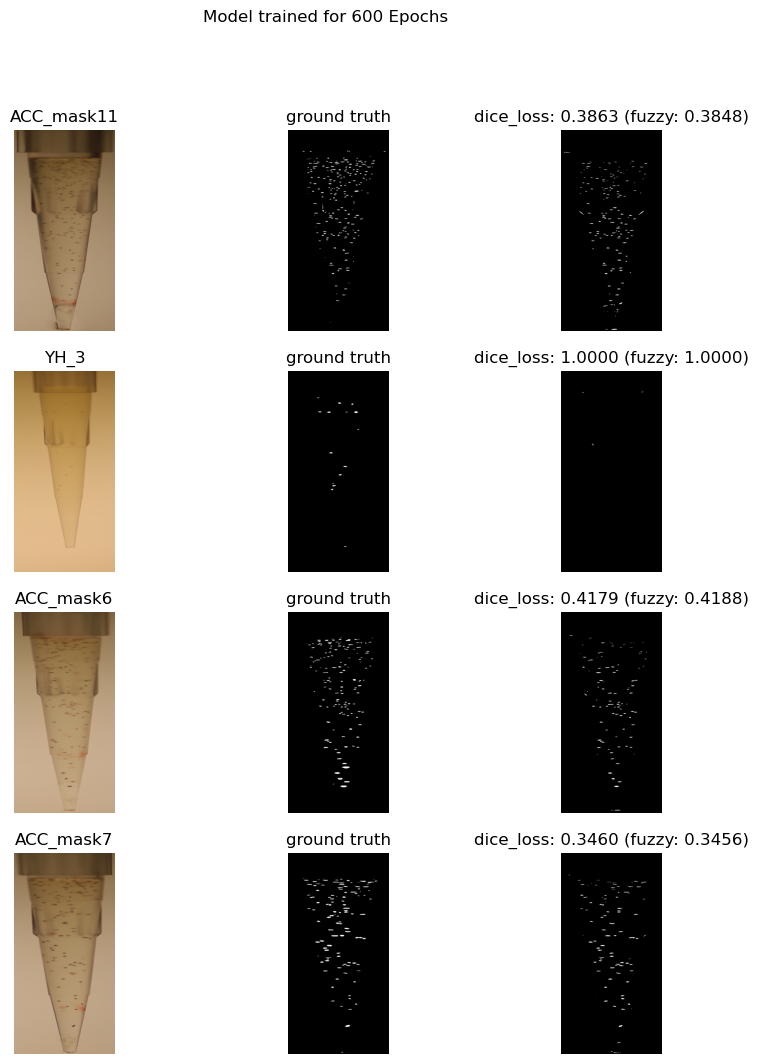

In [10]:
experiment.qualitative_eval(test_dataset)

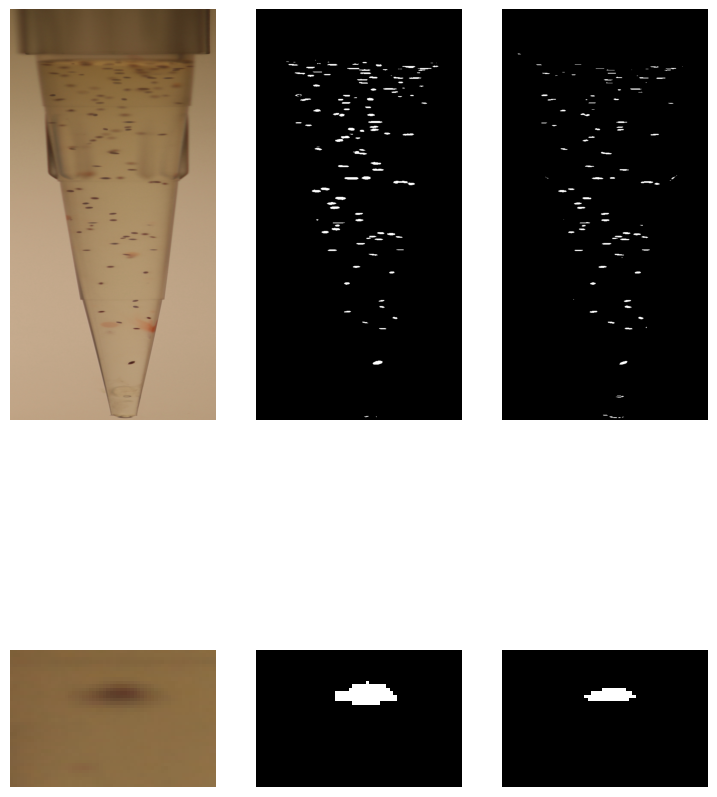

In [30]:
import matplotlib.pyplot as plt
with torch.no_grad():
    img, lab, file = test_dataset[3]
    img = img.to(device)
    img = img.unsqueeze(0)
    pred = experiment.model(img)
    
    img = img.squeeze()
    img = img.to('cpu')
    img = img.permute(1, 2, 0)
    
    pred = pred.to('cpu')
    pred = pred.squeeze()
    pred = pred > 0.5

    x_start = 240
    x_end = 280
    y_start = 120
    y_end = 180
    
    img_crop = img[x_start:x_end, y_start:y_end]
    pred_crop = pred[x_start:x_end, y_start:y_end]
    lab_crop = lab[x_start:x_end, y_start:y_end]
    
    fig, ax = plt.subplots(2, 3, figsize=(9, 12))
    ax[0, 0].imshow(img)
    ax[0, 0].axis('off')
    ax[0, 1].imshow(lab, cmap='gray')
    ax[0, 1].axis('off')
    ax[0, 2].imshow(pred, cmap='gray')
    ax[0, 2].axis('off')

    ax[1, 0].imshow(img_crop)
    ax[1, 0].axis('off')
    ax[1, 1].imshow(lab_crop, cmap='gray')
    ax[1, 1].axis('off')
    ax[1, 2].imshow(pred_crop, cmap='gray')
    ax[1, 2].axis('off')

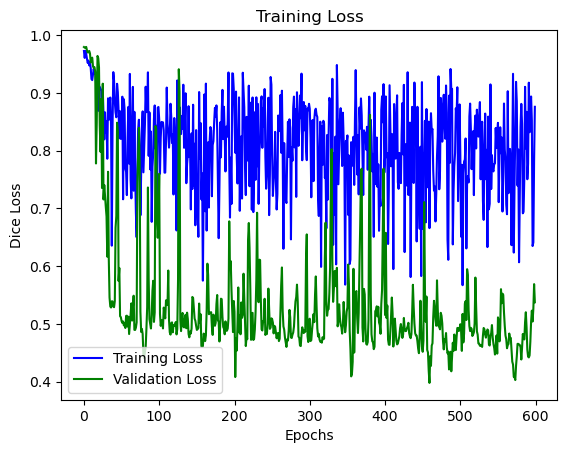

In [31]:
experiment.plot_loss()